# 05 — Customer Segmentation
Cluster customers into segments using RFM + sentiment features.
Then profile each segment in business terms.

## Step 1: Load and Prepare Features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Load customer features
df = pd.read_csv('../data/processed/customer_features.csv')
print(f'Shape: {df.shape}')
df.head()

c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


Shape: (96096, 10)


,customer_unique_id,recency,frequency,monetary,avg_order_value,num_products,avg_review_score,delivery_diff,avg_sentiment,num_reviews_with_text
0,d04921557f1cde4963c30a11dfb1719d,55,1,139.90,139.90,1,5.0,-11.0,0.0,0
1,d339ed835c9d8fd6b1e3c5cb60850bc5,614,1,239.20,239.20,1,5.0,-21.0,0.0,0
2,958da6ff0122fa69bc5e1dc0e176abd9,427,1,59.90,59.90,1,5.0,-19.0,0.0,0
3,86669cc06c6e824b3f2edfc2daef762e,111,1,49.99,49.99,1,5.0,-9.0,3.0,1
4,a6408b4025cdea6e80ebbc09aeb59dde,521,1,69.90,69.90,1,5.0,-21.0,0.0,0


## Step 2: Select and Scale Features
Clustering uses distance between points. If one feature ranges 0-600 (recency) and another 0-5 (review score),
recency will dominate. **StandardScaler** normalizes all features to mean=0, std=1 so they contribute equally.

In [2]:
# Select features for clustering
feature_cols = ['recency', 'frequency', 'monetary', 'avg_order_value',
                'num_products', 'avg_review_score', 'delivery_diff',
                'avg_sentiment', 'num_reviews_with_text']

X = df[feature_cols].copy()

# Check for any remaining nulls
print('Nulls per column:')
print(X.isnull().sum())
X = X.fillna(0)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'\nScaled shape: {X_scaled.shape}')
print(f'Mean of each feature (should be ~0): {X_scaled.mean(axis=0).round(2)}')
print(f'Std of each feature (should be ~1):  {X_scaled.std(axis=0).round(2)}')

Nulls per column:
recency                  0
frequency                0
monetary                 0
avg_order_value          0
num_products             0
avg_review_score         0
delivery_diff            0
avg_sentiment            0
num_reviews_with_text    0
dtype: int64

Scaled shape: (96096, 9)
Mean of each feature (should be ~0): [ 0. -0.  0.  0.  0.  0. -0.  0. -0.]
Std of each feature (should be ~1):  [1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Step 3: Find Optimal K
Use the **elbow method** (inertia) and **silhouette score** to pick the right number of clusters.
You know this — inertia always decreases, so look for the 'elbow' where it flattens.
Silhouette score measures how well-separated clusters are (higher = better, max = 1).

K=2: inertia=704,210, silhouette=0.303
K=3: inertia=598,098, silhouette=0.318
K=4: inertia=508,024, silhouette=0.330
K=5: inertia=428,110, silhouette=0.371
K=6: inertia=391,702, silhouette=0.281
K=7: inertia=363,413, silhouette=0.286
K=8: inertia=338,739, silhouette=0.297
K=9: inertia=322,605, silhouette=0.291
K=10: inertia=301,721, silhouette=0.271


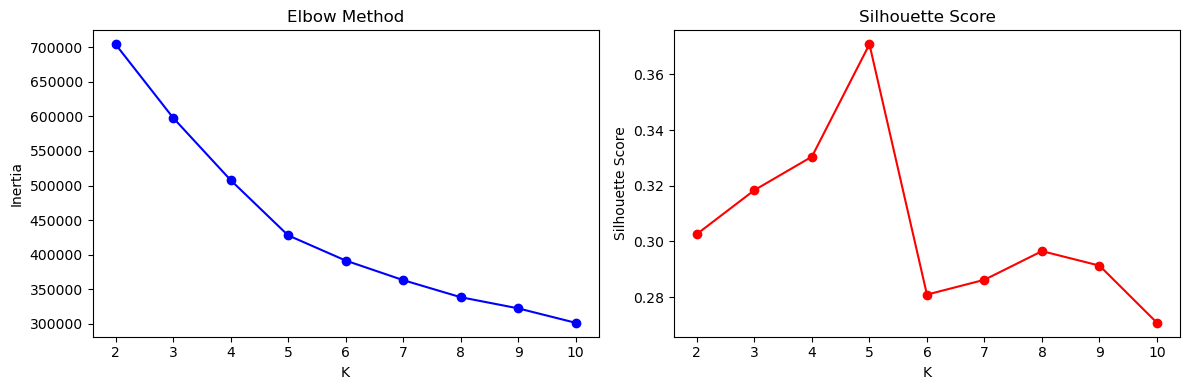

In [3]:
K_range = range(2, 11)
inertias = []
silhouettes = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels, sample_size=10000, random_state=42))
    print(f'K={k}: inertia={km.inertia_:,.0f}, silhouette={silhouettes[-1]:.3f}')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

axes[1].plot(K_range, silhouettes, 'ro-')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score')

plt.tight_layout()
plt.show()

## Step 4: Fit Final Model
Pick K based on the plots above and fit the final model.
Common choices are K=4 or K=5 for customer segmentation (enough to be useful, not so many that segments blur together).

In [5]:
# YOUR CHOICE: pick K based on the elbow/silhouette plots
K = 5  # Change this if a different K looks better

km_final = KMeans(n_clusters=K, random_state=42, n_init=10)
df['segment'] = km_final.fit_predict(X_scaled)

print(f'Silhouette score: {silhouette_score(X_scaled, df["segment"], sample_size=10000, random_state=42):.3f}')
print(f'\nSegment sizes:')
print(df['segment'].value_counts().sort_index())

Silhouette score: 0.371

Segment sizes:
segment
0    50093
1     1576
2    25877
3    15270
4     3280
Name: count, dtype: int64


## Step 5: Visualize Segments with PCA
We have 9 features — can't plot 9 dimensions. PCA reduces them to 2 dimensions for visualization.
PCA finds the 2 directions that capture the most variance in the data.

Variance explained by 2 components: 43.5%


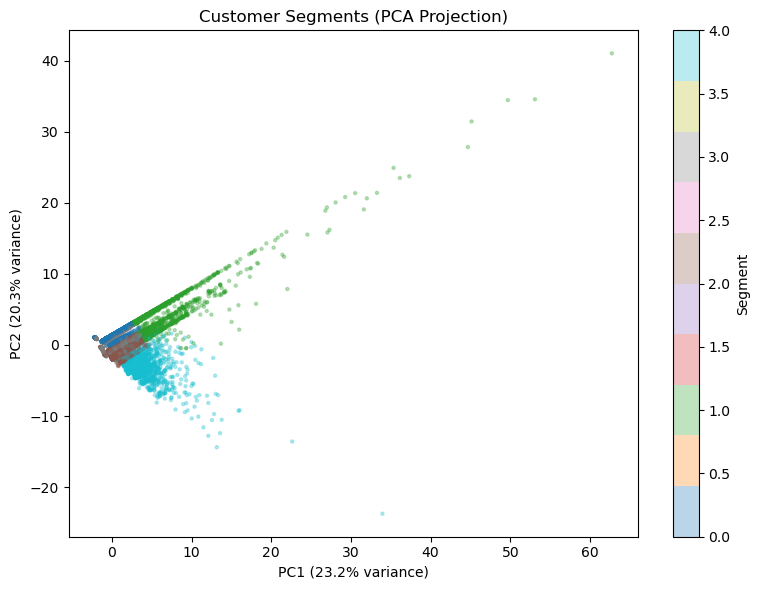

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f'Variance explained by 2 components: {pca.explained_variance_ratio_.sum():.1%}')

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=df['segment'], cmap='tab10', alpha=0.3, s=5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('Customer Segments (PCA Projection)')
plt.colorbar(scatter, label='Segment')
plt.tight_layout()
plt.show()

## Step 6: Profile Each Segment
This is the most important step. Numbers mean nothing without business context.
For each segment, look at the average feature values and describe WHO these customers are.

In [10]:
# Average features per segment
profiles = df.groupby('segment')[feature_cols].mean().round(2)
profiles['size'] = df.groupby('segment').size()
profiles['pct'] = (profiles['size'] / len(df) * 100).round(1)
profiles

,recency,frequency,monetary,avg_order_value,num_products,avg_review_score,delivery_diff,avg_sentiment,num_reviews_with_text,size,pct
segment,,,,,,,,,,,
0,283.58,1.00,117.16,117.16,1.02,4.58,-12.87,0.00,0.00,50093,52.1
1,293.65,1.02,1484.08,1459.87,1.05,3.88,-11.97,1.38,0.48,1576,1.6
2,295.29,1.00,123.19,123.19,1.02,4.64,-13.62,4.11,1.00,25877,26.9
3,294.17,1.00,130.67,130.66,1.02,1.38,-3.12,1.01,0.75,15270,15.9
4,269.77,2.01,269.07,140.40,2.21,4.01,-12.96,1.67,0.89,3280,3.4


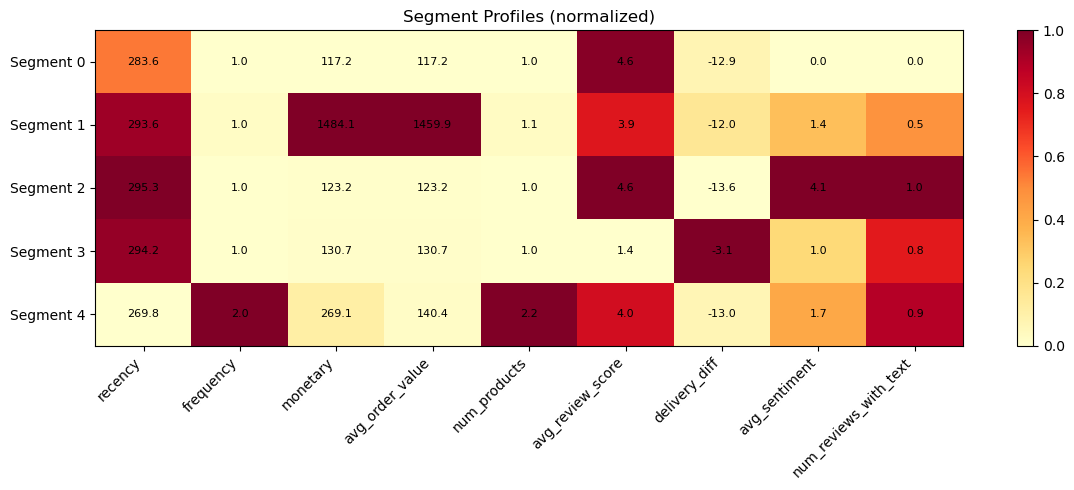

In [11]:
# Visualize segment profiles as a heatmap (normalized for comparison)
profiles_norm = profiles[feature_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

fig, ax = plt.subplots(figsize=(12, 5))
im = ax.imshow(profiles_norm.values, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(feature_cols)))
ax.set_xticklabels(feature_cols, rotation=45, ha='right')
ax.set_yticks(range(K))
ax.set_yticklabels([f'Segment {i}' for i in range(K)])
ax.set_title('Segment Profiles (normalized)')

# Add values
for i in range(K):
    for j in range(len(feature_cols)):
        ax.text(j, i, f'{profiles[feature_cols].values[i, j]:.1f}',
                ha='center', va='center', fontsize=8)

plt.colorbar(im)
plt.tight_layout()
plt.show()

## Step 7: Name Your Segments
Based on the profiles above, give each segment a business-friendly name.

**YOUR EXERCISE:** Look at the profile table and heatmap, then fill in names and descriptions below.
Think like a marketing team — what would you call each group?

Examples of good segment names:
- 'High-Value Loyalists' (high frequency, high monetary, high satisfaction)
- 'One-Time Bargain Shoppers' (low frequency, low monetary, low engagement)
- 'Churned / At Risk' (high recency, were active before)
- 'New Enthusiasts' (low recency, moderate spend, high sentiment)

In [12]:
# YOUR EXERCISE: fill in segment names based on the profiles
segment_names = {
    0: 'Silent Satisfied',
    1: 'High-Value Buyers',
    2: 'Engaged Enthusiasts',
    3: 'Dissatisfied / At Risk',
    4: 'Repeat Loyalists',
}

df['segment_name'] = df['segment'].map(segment_names)
print('Segment distribution:')
print(df['segment_name'].value_counts())

Segment distribution:
segment_name
Silent Satisfied          50093
Engaged Enthusiasts       25877
Dissatisfied / At Risk    15270
Repeat Loyalists           3280
High-Value Buyers          1576
Name: count, dtype: int64


## Step 8: Save

In [13]:
# Save updated customer features with segment labels
df.to_csv('../data/processed/customer_features.csv', index=False)
print(f'Saved: {df.shape}')
df[['customer_unique_id', 'segment', 'segment_name']].head(10)

Saved: (96096, 12)


,customer_unique_id,segment,segment_name
0,d04921557f1cde4963c30a11dfb1719d,0,Silent Satisfied
1,d339ed835c9d8fd6b1e3c5cb60850bc5,0,Silent Satisfied
2,958da6ff0122fa69bc5e1dc0e176abd9,0,Silent Satisfied
3,86669cc06c6e824b3f2edfc2daef762e,2,Engaged Enthusiasts
4,a6408b4025cdea6e80ebbc09aeb59dde,0,Silent Satisfied
5,580cb51ef32f77efc212a90937e83ce3,2,Engaged Enthusiasts
6,19fe66d478bfedfdcc743014d562b777,0,Silent Satisfied
7,dddcc50cec9aabfe44b26c136236db0a,2,Engaged Enthusiasts
8,71430416a809573ed4a01e04fa8e3b91,0,Silent Satisfied
9,e2fa02776abcbf7246ffd18f58e120ea,0,Silent Satisfied
